In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [5]:
MODEL_NAME = 'LSTM'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = LSTM, DEVICE = cpu


# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [11]:
Y = np.array([(np.sin(x), np.cos(x)) for x in X])
#Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
Y[:10]

array([[-0.03146104,  0.93720514],
       [ 0.17849704,  1.02254485],
       [ 0.2222776 ,  1.09716037],
       [ 0.53198877,  1.01294712],
       [ 0.43903848,  1.01616628],
       [ 0.58377143,  0.79700115],
       [ 0.52848385,  0.64627367],
       [ 0.74920861,  0.5571846 ],
       [ 0.81631235,  0.53349456],
       [ 1.11594502,  0.31347557]])

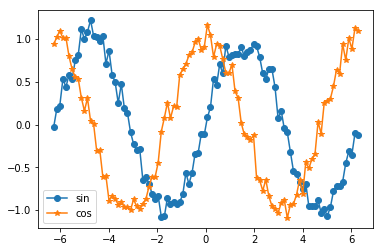

In [12]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

# Convert numpy array to torch.Tensor

In [13]:
# convert Y into input tensors
input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
#input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor.shape

torch.Size([100, 2])

In [14]:
# check input_tensor
input_tensor[:10]

tensor([[-0.0315,  0.9372],
        [ 0.1785,  1.0225],
        [ 0.2223,  1.0972],
        [ 0.5320,  1.0129],
        [ 0.4390,  1.0162],
        [ 0.5838,  0.7970],
        [ 0.5285,  0.6463],
        [ 0.7492,  0.5572],
        [ 0.8163,  0.5335],
        [ 1.1159,  0.3135]])

In [15]:
# make target_tensor by rotating input_tensor
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
#target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1785, 1.0225],
        [0.2223, 1.0972],
        [0.5320, 1.0129],
        [0.4390, 1.0162],
        [0.5838, 0.7970],
        [0.5285, 0.6463],
        [0.7492, 0.5572],
        [0.8163, 0.5335],
        [1.1159, 0.3135],
        [1.0000, 0.1601]])

In [16]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[-0.0315,  0.9372,  0.1785,  1.0225],
        [ 0.1785,  1.0225,  0.2223,  1.0972],
        [ 0.2223,  1.0972,  0.5320,  1.0129],
        [ 0.5320,  1.0129,  0.4390,  1.0162],
        [ 0.4390,  1.0162,  0.5838,  0.7970],
        [ 0.5838,  0.7970,  0.5285,  0.6463],
        [ 0.5285,  0.6463,  0.7492,  0.5572],
        [ 0.7492,  0.5572,  0.8163,  0.5335],
        [ 0.8163,  0.5335,  1.1159,  0.3135],
        [ 1.1159,  0.3135,  1.0000,  0.1601]])


# Create RNN Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size).to(DEVICE)
        self.h2o = nn.Linear(hidden_size, output_size).to(DEVICE)

    def forward(self, input, hidden):
#        print("input = {}".format(input))
#        print("hidden = {}".format(hidden))
#        print("reshaped = {}".format(input.view(1,1,-1)))         
        output, hidden = self.lstm(input.view(1,1,-1), hidden)
    
        h, c = hidden
        output = self.h2o(h)
        
        return output, hidden

    def initHidden(self):
#       return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)      
        return torch.zeros(1, 1, self.hidden_size).to(DEVICE), torch.zeros(1, 1, self.hidden_size).to(DEVICE)
      

# Train RNN

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
# define loss function

criterion = nn.MSELoss()

learning_rate = 0.0005


# define train function that trains for one step
def train(input_tensor, target_tensor):
#    hidden = rnn.initHidden().to(DEVICE)   # not necessary
    hidden = rnn.initHidden()

#    print("hidden = {}".format(hidden))
  
    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
#        print("Input = {}, hidden = {}".format(input_tensor[i], hidden))

        output, hidden = rnn(input_tensor[i:i+1], hidden)
  
#        print("output = {}, target = {}".format(output, target_tensor[i:i+1]))
    
        l = criterion(output, target_tensor[i:i+1])
        loss += l
        
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size(0)

### Note that pytorch modules inputs a batch rather than a vector!

In [20]:
# input_tensor[0].shape = torch.Size([2])
print("input_tensor[0] = {}, shape = {}".format(input_tensor[0], input_tensor[0].shape))

# input_tensor[0:1].shape = torch.Size([1, 2])
print("input_tensor[0:1] = {}, shape = {}".format(input_tensor[0:1], input_tensor[0:1].shape))

input_tensor[0] = tensor([-0.0315,  0.9372]), shape = torch.Size([2])
input_tensor[0:1] = tensor([[-0.0315,  0.9372]]), shape = torch.Size([1, 2])


In [0]:
rnn = RNN(2, 32, 2)

In [22]:
n_iters = 10000
print_every = 200
plot_every = 200
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (200 2%) 0.0157
0m 16s (400 4%) 0.0148
0m 25s (600 6%) 0.0144
0m 33s (800 8%) 0.0140
0m 42s (1000 10%) 0.0138
0m 50s (1200 12%) 0.0135
0m 59s (1400 14%) 0.0133
1m 7s (1600 16%) 0.0132
1m 16s (1800 18%) 0.0130
1m 24s (2000 20%) 0.0129
1m 33s (2200 22%) 0.0127
1m 41s (2400 24%) 0.0126
1m 49s (2600 26%) 0.0125
1m 58s (2800 28%) 0.0124
2m 6s (3000 30%) 0.0123
2m 15s (3200 32%) 0.0122
2m 24s (3400 34%) 0.0121
2m 32s (3600 36%) 0.0121
2m 40s (3800 38%) 0.0120
2m 48s (4000 40%) 0.0119
2m 57s (4200 42%) 0.0119
3m 5s (4400 44%) 0.0118
3m 13s (4600 46%) 0.0118
3m 22s (4800 48%) 0.0117
3m 30s (5000 50%) 0.0117
3m 39s (5200 52%) 0.0116
3m 47s (5400 54%) 0.0116
3m 56s (5600 56%) 0.0115
4m 4s (5800 57%) 0.0115
4m 13s (6000 60%) 0.0115
4m 21s (6200 62%) 0.0114
4m 29s (6400 64%) 0.0114
4m 38s (6600 66%) 0.0114
4m 46s (6800 68%) 0.0113
4m 54s (7000 70%) 0.0113
5m 3s (7200 72%) 0.0113
5m 11s (7400 74%) 0.0112
5m 19s (7600 76%) 0.0112
5m 28s (7800 78%) 0.0112
5m 36s (8000 80%) 0.0112
5m 44s (8200 8

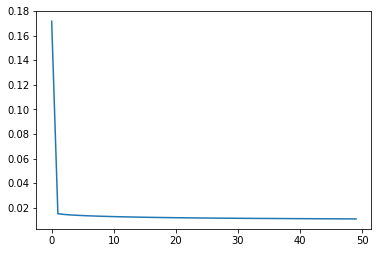

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [24]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]])
predict_tensor

tensor([[0.0032, 1.0000]])

In [0]:
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:], hidden)
  
#  print("output = {}".format(output[0]))
  
  predict_tensor = torch.cat((predict_tensor, output[0]), 0)
#  print("predict = {}".format(predict))

In [26]:
predict_tensor[:10]

tensor([[0.0032, 1.0000],
        [0.1799, 0.9281],
        [0.2872, 0.9786],
        [0.3964, 0.9708],
        [0.5036, 0.9264],
        [0.6054, 0.8575],
        [0.6987, 0.7710],
        [0.7808, 0.6716],
        [0.8501, 0.5625],
        [0.9052, 0.4463]], grad_fn=<SliceBackward>)

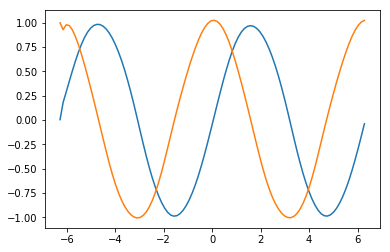

In [27]:
predict = predict_tensor.detach().numpy()
plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])
